# Time-Series Prediction

## Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet # facebook prophet

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.layers import GRU, Embedding, LSTM

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/esltester/anaconda3/envs/ml-course/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/esltester/anaconda3/envs/ml-course/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/esltester/anaconda3/envs/ml-course/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [2]:
#!pip install yfinance
#import yfinance as yf

In [3]:
#!pip install pandas_datareader
#from pandas_datareader import data as wb

### Get the data

In [4]:
traffic = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
# what is the shape?
traffic.shape

(48204, 9)

### Data quality and cleaning

In [6]:
# check for missingness
traffic.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [7]:
traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [22]:
# find records with all zeros
traffic[traffic.eq(0).all(1)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume


In [23]:
# what if we removed those columns?
traffic[traffic.any(axis=1)].shape

(48204, 9)

In [24]:
# check current size
traffic.shape

(48204, 9)

In [25]:
# actually remove column
traffic = traffic[traffic.any(axis=1)]
traffic.shape

(48204, 9)

Just because there seem to be no missing records does not mean that all of the values are valid. For example, temperature is recorded in Kelvin, and the minimum value is 0 (absolute 0). Traffic volume also drops to 0, though one could imagine that a very significant crash or other road closure could lead to this result.

<AxesSubplot:>

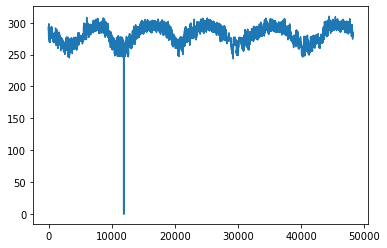

In [26]:
# potential outliers
display(traffic['temp'].plot())

The graph suggests that most of the values are in the appropriate ranges. We'll change the 0 values to NA, and then interpolate new values, as one would expect that the temperature values should be similar to those that come before and after. 

In [27]:
# change 0 to NA for temp
traffic['temp']=traffic['temp'].replace(0,np.nan)
# check for missingness
traffic.isnull().sum()

holiday                 0
temp                   10
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
date_time               0
traffic_volume          0
dtype: int64

In [28]:
# interpolate null values for temp
traffic['temp'] = traffic['temp'].interpolate()
traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.258909,0.334264,0.000222,49.362231,3259.818355
std,12.713614,44.789133,0.008168,39.015750,1986.860670
min,243.390000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


The max value for rain also looks suspect. We'll want to change that. This time, we'll use median.

<AxesSubplot:>

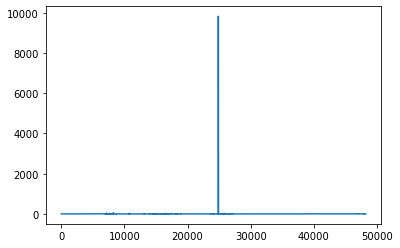

In [29]:
display(traffic['rain_1h'].plot())

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe8817f3490>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe8817f3d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe881848350>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe8817fd610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe8817fda50>],
 'means': []}

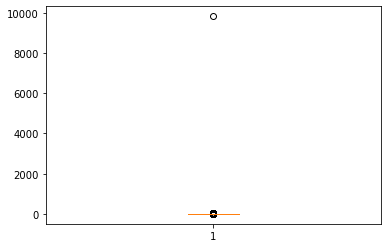

In [30]:
plt.boxplot(traffic['rain_1h'])

In [31]:
# set outliers to median
traffic[(traffic['rain_1h'] > 1000)] = traffic['rain_1h'].median()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe88176c410>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe88176cc90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe8817be750>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe881779590>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe8817799d0>],
 'means': []}

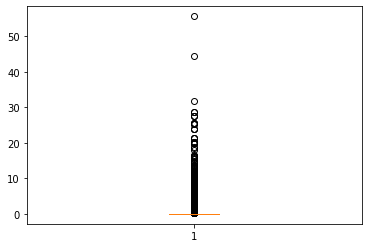

In [32]:
plt.boxplot(traffic['rain_1h'])

In [33]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40.0,Clouds,scattered clouds,2012-10-02 09:00:00,5545.0
1,None,289.36,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 10:00:00,4516.0
2,None,289.58,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 11:00:00,4767.0
3,None,290.13,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 12:00:00,5026.0
4,None,291.14,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 13:00:00,4918.0


In [34]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75.0,Clouds,broken clouds,2018-09-30 19:00:00,3543.0
48200,None,282.76,0.0,0.0,90.0,Clouds,overcast clouds,2018-09-30 20:00:00,2781.0
48201,None,282.73,0.0,0.0,90.0,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159.0
48202,None,282.09,0.0,0.0,90.0,Clouds,overcast clouds,2018-09-30 22:00:00,1450.0
48203,None,282.12,0.0,0.0,90.0,Clouds,overcast clouds,2018-09-30 23:00:00,954.0


In [35]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.703531
std       1986.889120
min          0.000000
25%       1192.750000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

We'll also want to make sure that we don't have any duplicate data.

In [36]:
# check for duplicates
duplicates = traffic[traffic.duplicated(keep=False)]
duplicates.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
18696,None,286.290,0.0,0.0,1.0,Clear,sky is clear,2015-09-30 19:00:00,3679.0
18697,None,286.290,0.0,0.0,1.0,Clear,sky is clear,2015-09-30 19:00:00,3679.0
23850,None,289.060,0.0,0.0,90.0,Clouds,overcast clouds,2016-06-01 10:00:00,4831.0
23851,None,289.060,0.0,0.0,90.0,Clouds,overcast clouds,2016-06-01 10:00:00,4831.0
26783,None,289.775,0.0,0.0,56.0,Clouds,broken clouds,2016-09-21 15:00:00,5365.0


In [37]:
# how many duplicates
duplicates.shape

(34, 9)

In [38]:
traffic.shape

(48204, 9)

In [39]:
# drop duplicates
traffic = traffic.drop_duplicates()

In [40]:
traffic.shape

(48187, 9)

We got rid of complete duplicates (i.e., those rows where every value in every column is repeated), but we also want to make sure that we don't have any repetition in the timestamps, as this is a time-series analysis.

In [41]:
traffic[traffic.duplicated(subset=['date_time'], keep=False)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
178,None,281.25,0.0,0.0,99.0,Rain,light rain,2012-10-10 07:00:00,6793.0
179,None,281.25,0.0,0.0,99.0,Drizzle,light intensity drizzle,2012-10-10 07:00:00,6793.0
180,None,280.10,0.0,0.0,99.0,Rain,light rain,2012-10-10 08:00:00,6283.0
181,None,280.10,0.0,0.0,99.0,Drizzle,light intensity drizzle,2012-10-10 08:00:00,6283.0
182,None,279.61,0.0,0.0,99.0,Rain,light rain,2012-10-10 09:00:00,5680.0
...,...,...,...,...,...,...,...,...,...
48112,None,285.17,0.0,0.0,90.0,Drizzle,light intensity drizzle,2018-09-27 07:00:00,6589.0
48192,None,283.48,0.0,0.0,90.0,Rain,light rain,2018-09-30 14:00:00,4380.0
48193,None,283.48,0.0,0.0,90.0,Drizzle,light intensity drizzle,2018-09-30 14:00:00,4380.0
48194,None,283.84,0.0,0.0,75.0,Rain,proximity shower rain,2018-09-30 15:00:00,4302.0


It looks like there is some variation in the weather_main and weather_description for the same times and data values. 

In [42]:
# get rid of duplicates, keeping first 
traffic = traffic.drop_duplicates(subset=['rain_1h', 'snow_1h', 'date_time', 'traffic_volume'])
traffic.shape

(40584, 9)

There also seem to be some places where the date_time is repeated, but the particular feature values (other than traffic volume) are different.

In [43]:
traffic[traffic.duplicated(subset=['date_time'], keep=False)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11603,None,275.89,0.64,0.0,64.0,Rain,light rain,2014-01-19 16:00:00,4410.0
11604,None,275.11,0.34,0.0,90.0,Rain,light rain,2014-01-19 16:00:00,4410.0
11725,None,272.15,0.00,0.0,64.0,Snow,light snow,2014-01-24 16:00:00,4880.0
11726,None,272.32,0.25,0.0,90.0,Rain,light rain,2014-01-24 16:00:00,4880.0
14783,None,294.54,0.54,0.0,40.0,Rain,light rain,2014-05-31 18:00:00,3881.0
14784,None,294.72,0.48,0.0,90.0,Rain,light rain,2014-05-31 18:00:00,3881.0
14795,None,292.38,1.85,0.0,68.0,Rain,moderate rain,2014-06-01 05:00:00,709.0
14798,None,292.32,2.10,0.0,90.0,Rain,moderate rain,2014-06-01 05:00:00,709.0
15270,None,294.68,1.20,0.0,90.0,Rain,moderate rain,2014-07-06 07:00:00,954.0
15272,None,294.80,0.90,0.0,90.0,Rain,moderate rain,2014-07-06 07:00:00,954.0


In [44]:
# what are the values of the weather description?
traffic.groupby(['weather_description'])['weather_description'].count()

weather_description
0.0                                        1
SQUALLS                                    1
Sky is Clear                            1724
broken clouds                           4650
drizzle                                  138
few clouds                              1950
fog                                      201
freezing rain                              1
haze                                     766
heavy intensity drizzle                   17
heavy intensity rain                     408
heavy snow                               500
light intensity drizzle                  360
light intensity shower rain               13
light rain                              2834
light rain and snow                        3
light shower snow                         11
light snow                              1588
mist                                    3069
moderate rain                           1383
overcast clouds                         5072
proximity shower rain              

In [45]:
# what about core weather?
traffic.groupby(['weather_main'])['weather_main'].count()

weather_main
0.0                 1
Clear           13366
Clouds          15124
Drizzle           515
Fog               201
Haze              766
Mist             3069
Rain             4776
Smoke              15
Snow             2297
Squall              1
Thunderstorm      453
Name: weather_main, dtype: int64

In [46]:
traffic.shape

(40584, 9)

In [47]:
# remove duplicate timestamps
traffic = traffic.drop_duplicates(subset=['date_time'])
traffic.shape

(40575, 9)

In [48]:
traffic['date_time_stamp'] = pd.to_datetime(traffic['date_time'], errors='raise', format = '%Y-%m-%d %H:%M:%S')

In [49]:
traffic['date_time_stamp'].head()

0   2012-10-02 09:00:00
1   2012-10-02 10:00:00
2   2012-10-02 11:00:00
3   2012-10-02 12:00:00
4   2012-10-02 13:00:00
Name: date_time_stamp, dtype: datetime64[ns]

In [50]:
traffic[traffic['date_time_stamp'] == traffic['date_time_stamp'].min()]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date_time_stamp
24872,0,0.0,0.0,0.0,0.0,0,0,0,0.0,1970-01-01


In [51]:
traffic[traffic['date_time_stamp'] == '1970-01-01']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date_time_stamp
24872,0,0.0,0.0,0.0,0.0,0,0,0,0.0,1970-01-01


In [52]:
traffic.shape

(40575, 10)

In [54]:
traffic = traffic.drop(24872)
traffic.shape

(40574, 10)

### Check dates

Do we have the full series?

In [64]:
days = traffic[['date_time_stamp', 'traffic_volume']]
datetime_index = pd.DatetimeIndex(days['date_time_stamp'].values)

In [65]:
newdays = days.set_index(datetime_index)
newdays.drop('date_time_stamp', axis=1,inplace=True)
newdays.head()

,traffic_volume
2012-10-02 09:00:00,5545.0
2012-10-02 10:00:00,4516.0
2012-10-02 11:00:00,4767.0
2012-10-02 12:00:00,5026.0
2012-10-02 13:00:00,4918.0


<AxesSubplot:>

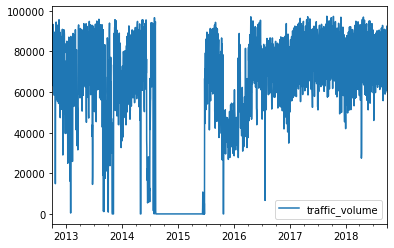

In [67]:
newdays.resample('D').sum().plot()

In [71]:
newdays.head(2)

,traffic_volume
2012-10-02 09:00:00,5545.0
2012-10-02 10:00:00,4516.0


In [72]:
newdays.tail(2)

,traffic_volume
2018-09-30 22:00:00,1450.0
2018-09-30 23:00:00,954.0


In [76]:
#check range
date_range = pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00',freq='1H')
# dummy data
df = pd.DataFrame(np.random.randint(1,20, (date_range.shape[0],1)))
df.index = date_range
df.head(2)

,0
2012-10-02 09:00:00,17
2012-10-02 10:00:00,5


In [77]:
df.tail(2)

,0
2018-09-30 22:00:00,13
2018-09-30 23:00:00,7


In [78]:
missing_dates = df.index[~df.index.isin(newdays.index)]
missing_dates

DatetimeIndex(['2012-10-03 07:00:00', '2012-10-03 10:00:00',
               '2012-10-03 11:00:00', '2012-10-03 17:00:00',
               '2012-10-05 02:00:00', '2012-10-05 04:00:00',
               '2012-10-06 03:00:00', '2012-10-07 01:00:00',
               '2012-10-07 02:00:00', '2012-10-09 03:00:00',
               ...
               '2018-03-24 05:00:00', '2018-03-24 06:00:00',
               '2018-03-24 07:00:00', '2018-03-29 02:00:00',
               '2018-05-05 02:00:00', '2018-06-02 02:00:00',
               '2018-08-07 07:00:00', '2018-08-07 08:00:00',
               '2018-08-07 09:00:00', '2018-08-23 02:00:00'],
              dtype='datetime64[ns]', length=11977, freq=None)

In [79]:
len(missing_dates)

11977

In [84]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date_time_stamp
0,None,288.28,0.0,0.0,40.0,Clouds,scattered clouds,2012-10-02 09:00:00,5545.0,2012-10-02 09:00:00
1,None,289.36,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 10:00:00,4516.0,2012-10-02 10:00:00
2,None,289.58,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 11:00:00,4767.0,2012-10-02 11:00:00
3,None,290.13,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 12:00:00,5026.0,2012-10-02 12:00:00
4,None,291.14,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 13:00:00,4918.0,2012-10-02 13:00:00


In [109]:
bob = pd.DataFrame({'date':traffic['date_time_stamp'].dt.date, 'value':np.random.randint(1,10)})
bob.head()

,date,value
0,2012-10-02,2
1,2012-10-02,2
2,2012-10-02,2
3,2012-10-02,2
4,2012-10-02,2


In [116]:
bob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40574 entries, 0 to 48203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    40574 non-null  object
 1   value   40574 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 951.0+ KB


In [118]:
newdays['2017-01-01':]

,traffic_volume
2017-01-01 00:00:00,1848.0
2017-01-01 01:00:00,1806.0
2017-01-01 02:00:00,1211.0
2017-01-01 03:00:00,794.0
2017-01-01 04:00:00,500.0
...,...
2018-09-30 19:00:00,3543.0
2018-09-30 20:00:00,2781.0
2018-09-30 21:00:00,2159.0
2018-09-30 22:00:00,1450.0


## Predictions with fbprophet

In [119]:
newdays.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40574 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  40574 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [140]:
to_use = newdays['2017-01-01':]
to_use.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15246 entries, 2017-01-01 00:00:00 to 2018-09-30 23:00:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  15246 non-null  float64
dtypes: float64(1)
memory usage: 238.2 KB


In [141]:
# create data frame in appropriate format
df = pd.DataFrame()
df['ds'] = to_use.index

In [130]:
#print(df[df.duplicated(keep=False)])

In [142]:
df.head()

,ds
0,2017-01-01 00:00:00
1,2017-01-01 01:00:00
2,2017-01-01 02:00:00
3,2017-01-01 03:00:00
4,2017-01-01 04:00:00


In [145]:
df['y']=to_use['traffic_volume'].values

In [146]:
df.head()

,ds,y
0,2017-01-01 00:00:00,1848.0
1,2017-01-01 01:00:00,1806.0
2,2017-01-01 02:00:00,1211.0
3,2017-01-01 03:00:00,794.0
4,2017-01-01 04:00:00,500.0


In [147]:
df.shape

(15246, 2)

In [148]:
#let's chop off some to make a test 
df_train = df[:10000]
df_test = df[10000:]
print(df_train.shape, df_test.shape)

(10000, 2) (5246, 2)


In [149]:
m = Prophet()
forecast = m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [150]:
# Preductions are made on a dataframe with a column ds (we will use the helper function Prophet.make_future_dataframe)
future = m.make_future_dataframe(periods=10574, freq='H')

In [151]:
future.head()

,ds
0,2017-01-01 00:00:00
1,2017-01-01 01:00:00
2,2017-01-01 02:00:00
3,2017-01-01 03:00:00
4,2017-01-01 04:00:00


In [152]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
20569,2019-05-10 02:00:00,-504.195557,-2774.202677,1494.451218
20570,2019-05-10 03:00:00,-332.302474,-2389.599396,1758.040181
20571,2019-05-10 04:00:00,576.724326,-1735.000552,2662.299416
20572,2019-05-10 05:00:00,1933.665105,-475.995851,3977.145532
20573,2019-05-10 06:00:00,3220.984053,930.168798,5294.409959


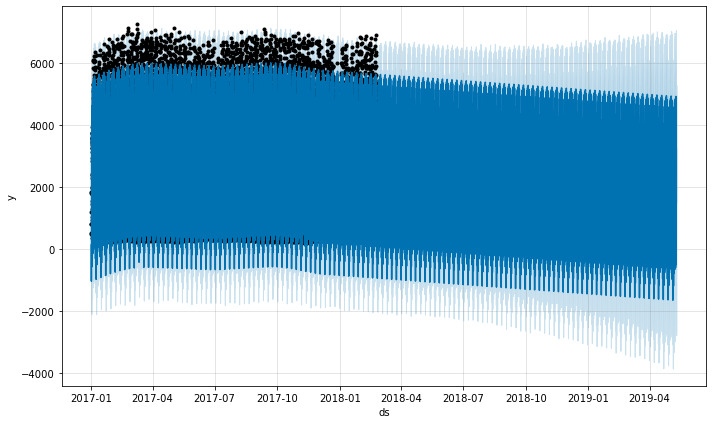

In [153]:
fig1 = m.plot(forecast)

### Download Stock Market Data using Yahoo Finance

In [ ]:
# Get the data of the stock AAPL
aapl = yf.download('AAPL','2019-01-01','2020-10-08')
# Plot the close price of the AAPL
aapl['Adj Close'].plot()
plt.title("Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.show()

In [ ]:
aapl.head()

In [ ]:
aapl.describe()

In [ ]:
aapl.info()

In [ ]:
#aapl_daily_returns = aapl['Adj Close'].pct_change()
#aapl_monthly_returns = aapl['Adj Close'].resample('M').ffill().pct_change()

A nice tutorial on financial data analysis: https://www.codingfinance.com/post/2018-04-03-calc-returns-py/

### Calculating the daily and monthly returns for individual stock:

Once we downloaded the stock prices from yahoo finance, the next thing to do is to calculate the returns. We will again use pandas package to do the calculations. We have already downloaded the price data for AAPL above, if you haven’t done that then see the above section. We will calculate the monthly and daily price returns.
```python
aapl_daily_returns = aapl['Adj Close'].pct_change()
aapl_monthly_returns = aapl['Adj Close'].resample('M').ffill().pct_change()
```

### Calculating the cumulative returns for individual stock:

Plotting the daily and monthly returns are useful for understanding the daily and monthly volatility of the investment. To calculate the growth of our investment or, in other words, calculating the total returns from our investment, we need to calculate the cumulative returns from that investment. To calculate the cumulative returns we will use the cumprod() function.
```python
aapl_cum_returns = (aapl_daily_returns + 1).cumprod()
```

#### Plot the data:
```python
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(aapl_cum_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("AAPL daily returns data")
plt.show()
```

### Download Several Stocks

In [ ]:
# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'IBM', 'MU', 'BA', 'AXP','GOOG','MSFT']

stock_data = pd.DataFrame(columns=tickers_list)
# Fetch the data

for ticker in tickers_list:
    stock_data[ticker] = yf.download(ticker, '2019-1-1', '2020-12-22')['Adj Close']
# Print first 5 rows of the data
#stock_data.head()


# Plot all the close prices
# the cumulative returns for individual stocks
((stock_data.pct_change()+1).cumprod()).plot(figsize=(10, 7))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()



In [ ]:
stock_data.head()

### Download Stock Market Data using Pandas DataReader

In [ ]:
#import datetime as dt

start = '2019-6-20'
end = '2019-7-20'

tickers = ['CSCO','AXP','HD','PG']

thelen = len(tickers)

price_data = []
for ticker in tickers:
    prices = wb.DataReader(ticker, start = start, end = end, data_source='yahoo')[['Adj Close']]
    price_data.append(prices.assign(ticker=ticker)[['ticker', 'Adj Close']])

stock_df = pd.concat(price_data)
#stock_df.dtypes
#stock_df.head()
#stock_df.shape


In [ ]:
stock_df

In [ ]:
# Create a pivot table to summarise data
stock_df = stock_df.reset_index()
stock_df = stock_df.set_index('Date')
table = stock_df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

In [ ]:
table.shape

In [ ]:
for column in table.columns:
    f = table[column] 
    #f = ((f.pct_change()+1).cumprod())
    f.plot(label=column);
    plt.legend()
    plt.ylabel('price in [USD]')

plt.show()

In [ ]:
# Plot all the close prices
# the cumulative returns for individual stocks
((table.pct_change()+1).cumprod()).plot(figsize=(10, 7))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

### Load Data from a Table (csv)

In [ ]:
water_data = pd.read_csv('WaterLevel-Dataset.csv')

Reverse data as it is ordered backwards

In [ ]:
water_data = water_data.iloc[::-1]
water_data.reset_index(inplace=True, drop=True)
water_data.head()

### Check if there any Missing Data

In [ ]:
water_data.isnull().sum()

### Set the Date column as index

In [ ]:
# convert to datetime
water_data['Date'] = pd.to_datetime(water_data['Date'])

# set the index
water_data.set_index('Date', inplace=True)
water_data.info()

In [ ]:
water_data.head()

### Visualise Data

In [ ]:
water_data['Capacity (%)'].plot()

In [ ]:
water_data['Water Level (m)'].plot()

In [ ]:
water_data.values.shape

### Split the Data into Train/test subsets .. ONLY use IBM

In [ ]:
stock_data.shape

In [ ]:
data = stock_data['IBM']
data.plot()

In [ ]:
train_df = data[:420]#aapl['Adj Close'][:250]#df['Water Level (m)'][0:100]
print('train shape:', train_df.shape)
test_df = data[420:]#aapl['Adj Close'][250:]#df['Water Level (m)'][100:]
print('test shape: ',test_df.shape)

print("Min x:", np.min(train_df))
print("Max x:", np.max(train_df))

### Normalise the Data into values between 0 and 1

In [ ]:
## After this step train and test will become numpy matrices instead of pandas dataframes
## NOTICE: we use the model that is fitted to the train data to scale the test data .. 
## very important to do it this way!

x_scaler = MinMaxScaler()
train = x_scaler.fit_transform(train_df.values.reshape(-1, 1))
test = x_scaler.transform(test_df.values.reshape(-1, 1))

In [ ]:
# make sure values are between 0-1
print("Min x:", np.min(train))
print("Max x:", np.max(train))

### To Split Data into Sequences


In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#### Create sequences for training data

In [ ]:
seq = [1,2,3,4,5,6,7,8,9,10]
steps = 3
split_sequence(seq,steps)

In [ ]:
# define input sequence
train #train['Capacity (%)'].values
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(train, n_steps)

In [ ]:
X_train

#### Create sequences for test data

In [ ]:
# define test sequence
#test_raw_seq = test #test['Capacity (%)'].values
# choose a number of time steps .. same as training!
#n_steps = 5
# split into samples
X_test, y_test = split_sequence(test, n_steps)
#X_test.shape

#### Data Shape suitable for feeding into TF/Keras

In [ ]:
print(X_train.shape)
print(X_test.shape)

## Model Building and Fitting (RNN, LSTM and GRU)

In [ ]:
n_features = 1

# define model
model = Sequential()

# Single layer GRU
#model.add(GRU(32 , input_shape=(n_steps, n_features) ))

# Stacked GRU
#model.add(GRU(8 , input_shape=(n_steps, n_features) , return_sequences=True))
#model.add(GRU(16, return_sequences=True))
#model.add(GRU(32))

# Stacked LSTM 
# each step is 5 by 1
model.add(LSTM(8, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1, callbacks=[es, mc])

# fit model
#model.fit(X_train, y_train, epochs=50, verbose=1, callbacks=[es, mc])

In [ ]:
history.history

In [ ]:
## visualise performance (training loss vs validation loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Building and Fitting CNN

In [ ]:
n_features = 1
# define model
model = Sequential()
#model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, epochs=20, verbose=1)


### Load the saved model

In [ ]:
from keras.models import load_model
# DON'T LOAD IF RUNNING CNN
# load the saved model
model = load_model('best_model.h5')

#### Compute RMSE for Evaluation

In [ ]:
def rmse(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true))) 

In [ ]:
preds = []
# demonstrate predictions
for i in range(X_test.shape[0]):
    x_input = X_test[i]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    preds.append(yhat[0])
    #print(yhat[0], y_test[i])

In [ ]:
#preds

### After getting the predictions we need to transform the predicted and actual Y values into their original range
### Remember we applied scaling previously

In [ ]:
# The output of the model is between 0 and 1.
# Do an inverse map to get it back to the scale
# of the original data-set.
preds   = x_scaler.inverse_transform(np.array(preds))
# we also rescale the y_test values into their original range (inverse scaling)
actuals = x_scaler.inverse_transform(y_test)

In [ ]:
rmse(actuals, preds)

#### Plot True vs Predicted

In [ ]:
# multiple line plot
plt.plot(actuals, marker='o', label='True')
plt.plot(preds, marker='*', label='Predicted')

plt.legend()

# WELL DONE!